링크 :https://github.com/Harry24k/PGD-pytorch/blob/master/PGD.ipynb

# 0.Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/'[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구'/3. 소스코드

/content/drive/MyDrive/[한이음] 적대적 AI 공격에 대한 인공지능 보안기술 연구/3. 소스코드


# 1. Requirements

In [3]:
import numpy as np
import json

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data

import torchvision.utils
from torchvision import models
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# 2. Set Args

In [5]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")

# 3. Prepare Data

In [23]:
# https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
class_idx = json.load(open("./PGD/data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))] # <class 'list'>

In [7]:
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
])

In [24]:
def image_folder_custom_label(root, transform, custom_label) :
    
    # custom_label
    # type : List
    # index -> label
    # ex) ['tench', 'goldfish', 'great_white_shark', 'tiger_shark']
    
    old_data = dsets.ImageFolder(root = root, transform = transform)
    old_classes = old_data.classes # 리스트 형

    print(old_classes)
    
    label2idx = {}
    
    for i, item in enumerate(idx2label) :
        label2idx[item] = i
    
    new_data = dsets.ImageFolder(root = root, transform = transform, 
                                 target_transform = lambda x : custom_label.index(old_classes[x]))
    new_data.classes = idx2label
    new_data.class_to_idx = label2idx

    return new_data

In [25]:
normal_data = image_folder_custom_label(root = './PGD/data/imagenet', transform = transform, custom_label = idx2label)
normal_loader = Data.DataLoader(normal_data, batch_size=1, shuffle=False)

['giant_panda']


In [27]:
print(type(normal_data))

<class 'torchvision.datasets.folder.ImageFolder'>


In [10]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

True Image & True Label


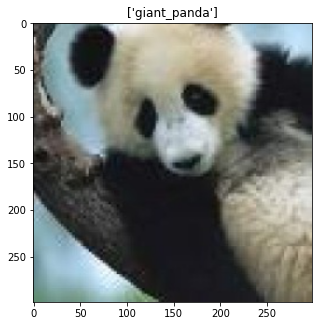

In [11]:
normal_iter = iter(normal_loader)
images, labels = normal_iter.next()

print("True Image & True Label")
imshow(torchvision.utils.make_grid(images, normalize=True), [normal_data.classes[i] for i in labels])

# 4. Download the Inception v3

In [12]:
model = models.inception_v3(pretrained=True).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

True Image & Predicted Label


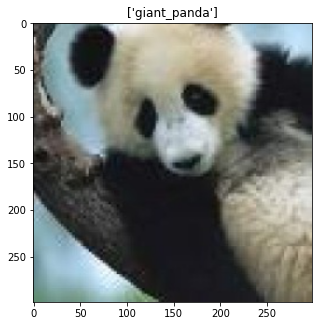

Accuracy of test text: 100.000000 %


In [13]:
print("True Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)
    
    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
        
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))

# 5. Adversarial Attack

In [14]:
# PGD Attack
# MNIST init
def pgd_attack(model, images, labels, eps=0.3, alpha=2/255, iters=40) :
    images = images.to(device)
    labels = labels.to(device)
    loss = nn.CrossEntropyLoss()
        
    ori_images = images.data
        
    for i in range(iters) :    
        images.requires_grad = True
        outputs = model(images)

        model.zero_grad()
        cost = loss(outputs, labels).to(device)
        cost.backward()

        adv_images = images + alpha*images.grad.sign()
        eta = torch.clamp(adv_images - ori_images, min=-eps, max=eps)
        images = torch.clamp(ori_images + eta, min=0, max=1).detach_()
            
    return images

Attack Image & Predicted Label


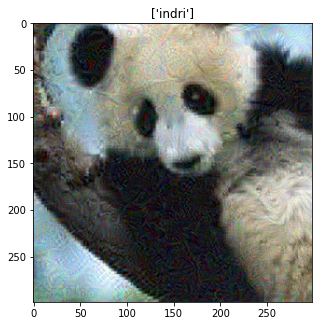

Accuracy of test text: 0.000000 %


In [15]:
print("Attack Image & Predicted Label")

model.eval()

correct = 0
total = 0

for images, labels in normal_loader:
    
    images = pgd_attack(model, images, labels)
    labels = labels.to(device)
    outputs = model(images)
    
    _, pre = torch.max(outputs.data, 1)

    total += 1
    correct += (pre == labels).sum()
    
    imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [normal_data.classes[i] for i in pre])
    
print('Accuracy of test text: %f %%' % (100 * float(correct) / total))